In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [10]:
data_dir = r'F:\MV\Dataset\HAM1000\hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 2353 entries, pixel0000 to label
dtypes: int64(2353)
memory usage: 179.8 MB


In [12]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [13]:
data["label"].value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

In [14]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [15]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6], dtype=int64)

In [16]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2: ('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [17]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(35201,)
(11734, 28, 28, 3)
(11734,)


In [19]:
from tensorflow.python.keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [20]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [21]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, AveragePooling2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Add, Multiply

def squeeze_excitation_block(x, ratio=8):
    channels = int(x.shape[-1])
    se = GlobalAveragePooling2D()(x)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = tf.keras.layers.Reshape((1, 1, channels))(se)
    scaled = Multiply()([x, se])
    return scaled

def depthwise_inception_resnet_attention(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # Inception-ResNet module
    def inception_resnet_block(x, scale=1.0):
        conv1 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)

        conv2_1 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
        conv2_1 = DepthwiseConv2D(3, padding='same', activation='relu')(conv2_1)

        conv2_2 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
        conv2_2 = DepthwiseConv2D(5, padding='same', activation='relu')(conv2_2)

        inception_block = Concatenate(axis=-1)([conv1, conv2_1, conv2_2])

        # Attention mechanism
        attention = squeeze_excitation_block(inception_block)

        # Residual connection
        scaled_block = Conv2D(int(x.shape[-1]), (1, 1), padding='same', activation='linear')(attention)
        scaled_block = BatchNormalization()(scaled_block)

        out = Add()([x, scaled_block])
        out = ReLU()(out * scale)

        return out

    # Initial convolution
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_tensor)

    # Depthwise Inception-ResNet blocks with attention
    x = inception_resnet_block(x)
    x = inception_resnet_block(x)
    x = inception_resnet_block(x)

    # Global average pooling and dense layers
    x = GlobalAveragePooling2D()(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)

    return model




In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, AveragePooling2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Add, Multiply
from tensorflow.keras.layers import concatenate

def squeeze_excitation_block(x, ratio=8):
    channels = int(x.shape[-1])
    se = GlobalAveragePooling2D()(x)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    se = tf.keras.layers.Reshape((1, 1, channels))(se)
    scaled = Multiply()([x, se])
    return scaled

def depthwise_inception_resnet_attentionB(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # Inception-ResNet module
    def inception_resnet_block(x, scale=1.0):
         # Branch 1
        branch_1_conv_1x1 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
    
        # Branch 2
        branch_2_conv_1x1 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
        branch_2_conv_1x1_dw = DepthwiseConv2D(3, padding='same', activation='relu')(branch_2_conv_1x1)
    
        # Branch 3
        branch_3_conv_1x1 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
        branch_3_conv_1x7 = Conv2D(32, (1, 7), padding='same', activation='relu')(branch_3_conv_1x1)
        branch_3_conv_7x1 = Conv2D(32, (7, 1), padding='same', activation='relu')(branch_3_conv_1x7)
        branch_3_conv_7x1_dw = DepthwiseConv2D(3, padding='same', activation='relu')(branch_3_conv_7x1)
    
        # Branch 4
        branch_4_conv_1x1 = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
        branch_4_conv_1x7a = Conv2D(32, (1, 7), padding='same', activation='relu')(branch_4_conv_1x1)
        branch_4_conv_7x1a = Conv2D(32, (7, 1), padding='same', activation='relu')(branch_4_conv_1x7a)
        branch_4_conv_1x7b = Conv2D(32, (1, 7), padding='same', activation='relu')(branch_4_conv_7x1a)
        branch_4_conv_7x1b = Conv2D(32, (7, 1), padding='same', activation='relu')(branch_4_conv_1x7b)
        branch_4_conv_7x1b_dw = DepthwiseConv2D(3, padding='same', activation='relu')(branch_4_conv_7x1b)
        
        inception_block = concatenate([branch_1_conv_1x1, branch_2_conv_1x1_dw, branch_3_conv_7x1_dw, branch_4_conv_7x1b_dw], axis=-1)



        # Attention mechanism
        attention = squeeze_excitation_block(inception_block)

        # Residual connection
        scaled_block = Conv2D(int(x.shape[-1]), (1, 1), padding='same', activation='linear')(attention)
        scaled_block = BatchNormalization()(scaled_block)

        out = Add()([x, scaled_block])
        out = ReLU()(out * scale)

        return out

    # Initial convolution
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_tensor)

    # Depthwise Inception-ResNet blocks with attention
    x = inception_resnet_block(x)
    x = inception_resnet_block(x)
    x = inception_resnet_block(x)

    # Global average pooling and dense layers
    x = GlobalAveragePooling2D()(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_tensor, outputs=output_tensor)

    return model




In [24]:
# Set input shape and number of classes
input_shape = (28, 28, 3)  # Example input shape, adjust based on your requirements
num_classes = 7  # Adjust based on your classification task

# Create the InceptionNet model
model = depthwise_inception_resnet_attention(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 28, 28, 32)   2080        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 32)   2080        ['conv2d[0][0]']                 
                                                                                              

In [25]:
# Set input shape and number of classes
input_shape = (28, 28, 3)  # Example input shape, adjust based on your requirements
num_classes = 7  # Adjust based on your classification task

# Create the InceptionNet model
model2 = depthwise_inception_resnet_attentionB(input_shape, num_classes)

from keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 28, 28, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 28, 28, 32)   2080        ['conv2d_13[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 28, 28, 32)   7200        ['conv2d_19[0][0]']              
                                                                                            

In [26]:
history2 = model2.fit(X_train ,
                    y_train ,
                    epochs=10 ,
                    batch_size=32,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/10
1101/1101 [==============================] - 48s 35ms/step - loss: 2.5566 - accuracy: 0.3917 - val_loss: 5.5415 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/10
1101/1101 [==============================] - 37s 33ms/step - loss: 1.3488 - accuracy: 0.5460 - val_loss: 2.2413 - val_accuracy: 0.4988 - lr: 0.0010
Epoch 3/10
1101/1101 [==============================] - 37s 33ms/step - loss: 1.0145 - accuracy: 0.6448 - val_loss: 1.1472 - val_accuracy: 0.6369 - lr: 0.0010
Epoch 4/10
1101/1101 [==============================] - 37s 34ms/step - loss: 0.7389 - accuracy: 0.7300 - val_loss: 1.9008 - val_accuracy: 0.4858 - lr: 0.0010
Epoch 5/10
1101/1101 [==============================] - 39s 35ms/step - loss: 0.6068 - accuracy: 0.7761 - val_loss: 0.7607 - val_accuracy: 0.7547 - lr: 0.0010
Epoch 6/10
1101/1101 [==============================] - 38s 35ms/step - loss: 0.4896 - accuracy: 0.8180 - val_loss: 0.6865 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 7/10
1099/1101 [========================

In [27]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

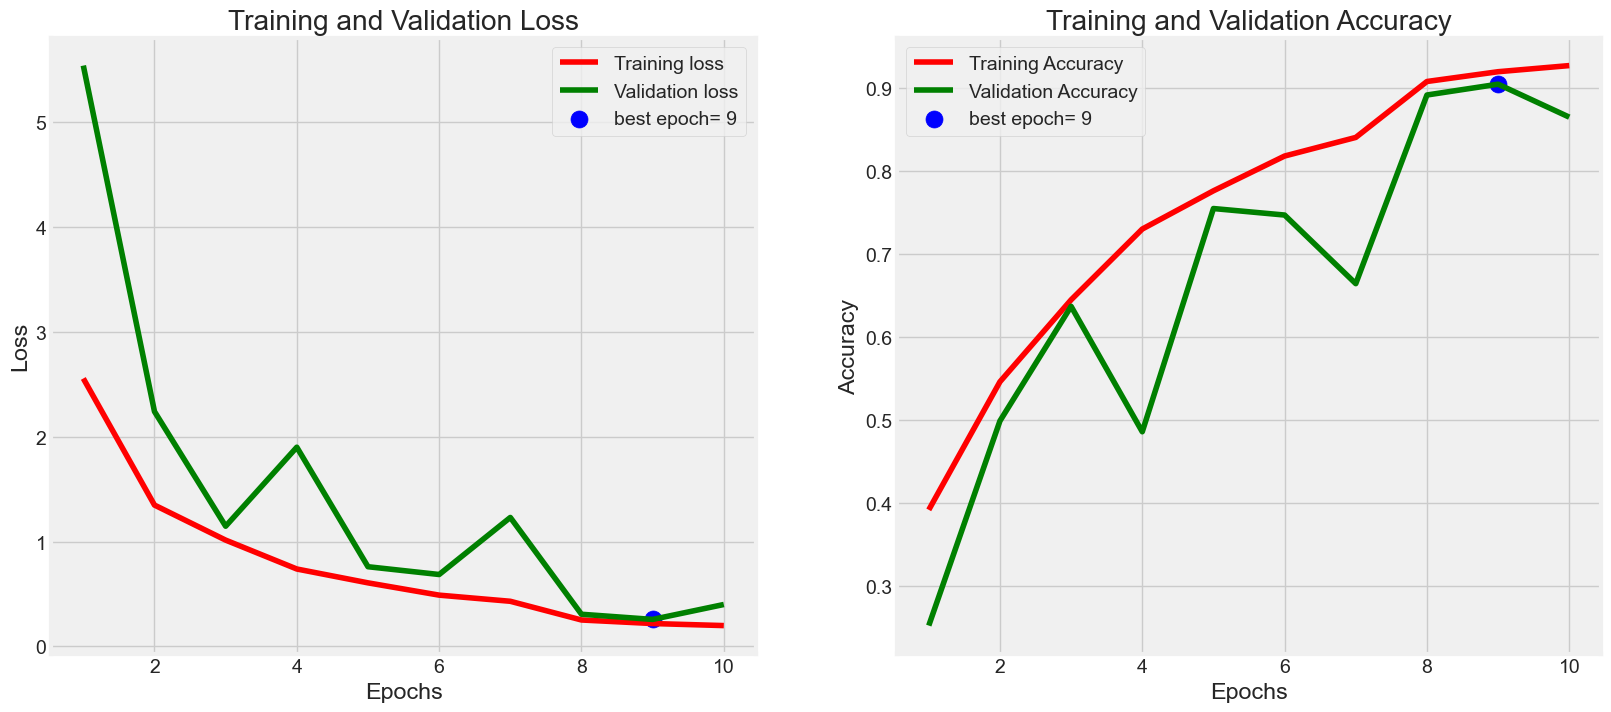

In [28]:
plot_training(history2)

In [29]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=10 ,
                    batch_size=32,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/10
 114/1101 [==>...........................] - ETA: 1:07 - loss: 8.1823 - accuracy: 0.2149

KeyboardInterrupt: 

In [30]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

In [31]:
plot_training(history)

NameError: name 'history' is not defined

In [ ]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

In [ ]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

In [ ]:
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#model.save('Skin Cancer.h5')

In [ ]:
from keras import backend as K
import gc

del model2

K.clear_session()
gc.collect()

In [ ]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()